In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt

In [2]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
averaging = '5daily'
vgrid = 'native'
filename = '19000101.ocean_'+averaging+'_'+vgrid+'_19*.nc'
filename_grid = '19000101.ocean_static.nc'
ds = xr.open_mfdataset(rootdir+filename, combine='by_coords')
delta_t = ds['average_DT'].astype('timedelta64[s]')
grid = xr.open_dataset(rootdir+filename_grid)

cp = 3992.0
rho0 = 1035.0

if vgrid == 'z':
    ds = ds.rename({'z_l':'zl'})

In [3]:
# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
h_terms = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency','internal_heat_h_tendency']

In [4]:
# Calculate material derivative and diffusive terms
# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# SALT
signsLHS = [-1,1,1]
signsRHS = [1,1,1]
termsLHS = salt_terms[:3]
termsRHS = salt_terms[3:]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [49]:
def calc_E_wrapper(l,dls,l_i_vals,c=None,weight=None,dims=['xh','yh','zl']):
    '''Wrapper for calc_E to allow evaluation of contributions from different processes,
    each represented as a DataArray in the Dataset [dls].
    l : xr.DataArray;
        Intensive variable (e.g. temp) that defines layers across which transport
        will be determined.
    dls : xr.Dataset;
        Tendencies of l due to differnt diffusive processes,
        e.g. horizontal and vertical diffusion tendencies
        Multiple processes are included as Dataarrays inside a dataset.
    l_i_vals : ndarray or xr.DataArray;
        Interface values of l; transport will be across midpoints of these interfaces
    c : None or scalar or xr.DataArray
        If included, evaluating transport of tracer as opposed to volume
        A scalar could be density, to get mass rather than volume transport
    weight : xr.DataArray;
        Distribution of weights by which to multiply [dl] to remove spatial
        dimension of units. E.g. heat flux in Wm-2 should be multiplied by the area
        of the grid cell to recover total heating.
    dims : list of string;
        Dimensions along which to perform histogram.'''
    
    import xarray as xr
    
    # Set up dataset for contributions to E
    E = xr.Dataset()
    for var in dls.data_vars:
        dl = dls[var]
        E[var] = calc_E(l,dl,l_i_vals,c=c,weight=weight,dims=dims)
        
    return E

In [50]:
def calc_E(l,dl,l_i_vals,c=None,weight=None,dims=['xh','yh','zl']):
    '''Transport of mass or tracer across contours of [l], due to processes [dl].
    l : xr.DataArray;
        Intensive variable (e.g. temp) that defines layers across which transport
        will be determined.
    dl : xr.DataArray;
        Tendency of l due to (individual or total sum of) diffusive processes,
        e.g. heat tendencies
        Multiple processes are included as Dataarrays inside a dataset.
    l_i_vals : ndarray or xr.DataArray;
        Interface values of l; transport will be across midpoints of these interfaces
    c : None or scalar or xr.DataArray
        If included, evaluating transport of tracer as opposed to volume
        A scalar could be density, to get mass rather than volume transport
    weight : xr.DataArray;
        Distribution of weights by which to multiply [dl] to remove spatial
        dimension of units. E.g. heat flux in Wm-2 should be multiplied by the area
        of the grid cell to recover total heating.
    dims : list of string;
        Dimensions along which to perform histogram.'''
    
    import xarray as xr
    import numpy as np
    from xhistogram.xarray import histogram
    
    # Get the spacing of contours of l
    delta_l_vals = np.diff(l_i_vals)
    # xhistogram has some curiousities around nan-values, so exclude them
    nanmask = np.isnan(l)
    
    # Specify what should be integrated
    # (this is rather clunky with if statements, but is meant to avoid loading
    # unnecessary variables, such as dummy [c]'s or [weight]'s)
    if c==None:
        if weight==None:
            weights = dl
        else:
            weights = dl*weight
    else:
        if weight==None:
            weights = c*dl
        else:
            weights = c*dl*weight
            
    # Integrate [weights] within layers of [l] and divide by [delta_l]
    E = histogram(l.where(~nanmask),
                  bins=[l_i_vals],
                  weights=weights.where(~nanmask),
                  dim=dims,
                  block_size=1)/delta_l_vals
    
    return E

In [54]:
dls = ds[heat_terms[3:]]/cp/rho0
l = ds['temp']
c = rho0
l_i_vals = np.arange(-4,34,0.5)
weight = grid.areacello
E = calc_E_wrapper(l=l, dls=dls, l_i_vals=l_i_vals, c=c, weight=weight)

In [76]:
def calc_volumetric_cumsum(l,p,l_l_vals,weight=None,dims=['xh','yh','zl'],greaterthan=True,):
    '''Integration of quantity [p] across volume with [l] greater than layer defined
    by contours l_l_vals.
    
    *** IMPORTANT *** 
    Limits of l_l_vals must span the full range of l.
    *****************
    
    l : xr.DataArray;
        Intensive variable, to define volume boundary
    p : xr.DataArray;
        Quantity to be integrated (e.g. thickness)
    l_l_vals : ndarray or xr.DataArray
        Values of the contours for which the integration will be calculated
        *** This is currently set up such that the layer values are increasing ***
        *** I expect it can be generalized, but have not explored this yet     ***
    weight : Distribution of weights by which to multiply [p] to remove spatial
        dimension of units. E.g. thickness in units 'm' should be multiplied by the area
        of the grid cell to recover total volume.
    greaterthan : boolean;
        True if the integral should be over contours 
        greater than each contour. False for less than.'''
    
    import xarray as xr
    import numpy as np
    from xhistogram.xarray import histogram
    
    # xhistogram has some curiousities around nan-values, so exclude them
    nanmask = np.isnan(l)
    
    # Specify what should be integrated
    if weight is None:
        weights = p
    else:
        weights = p*weight
        
    # Integrate p between each contour layer
    P_l = histogram(l.where(~nanmask),bins=[l_l_vals],weights=weights.where(~nanmask),dim=dims,block_size=1)
    # Cumulatively sum each layer (concatenate zeros at start), and take away from total sum to reverse the order of the summation
    # i.e. this the cumulative sum of integrated [p] from largest to smallest [l_l]
    P_l_cumsum = xr.concat([xr.zeros_like(P_l.isel({l.name+'_bin':0})),P_l.cumsum(l.name+'_bin')],dim=l.name+'_bin')
    if greaterthan:
        # Take cumulative sum away from total sum to reverse the order
        # Assign coordinates to match the contours (rather than the interfaces)
        P = (P_l.sum(l.name+'_bin')-P_l_cumsum).assign_coords({l.name+'_bin':l_l_vals})
    else:
        P = P_l_cumsum.assign_coords({l.name+'_bin':l_l_vals})
                                                                          
    return P

In [77]:
def calc_P_wrapper(l,ps,l_l_vals,weight=None,dims=['xh','yh','zl'],greaterthan=True):
    '''Wrapper for calc_P to allow integration of numerous quantities,
    each represented as a DataArray in the Dataset [ps].
    
    *** IMPORTANT *** 
    Limits of l_l_vals must span the full range of l.
    *****************
    
    l : xr.DataArray;
        Intensive variable (e.g. temp) that defines layers across which transport
        will be determined.
    ps : xr.Dataset;
        Quantities for integration.
        Multiple quantities are included as Dataarrays inside a dataset.
    l_l_vals : ndarray or xr.DataArray
        Values of the contours for which the integration will be calculated
        *** This is currently set up such that the layer values are increasing ***
        *** I expect it can be generalized, but have not explored this yet     ***
    weight : xr.DataArray
        Distribution of weights by which to multiply [p] to remove spatial
        dimension of units. E.g. thickness in units 'm' should be multiplied by the area
        of the grid cell to recover total volume.
    greaterthan : boolean;
        True if the integral should be over contours 
        greater than each contour. False for less than.'''
    
    import xarray as xr
    
    # Set up dataset for contributions to E
    P = xr.Dataset()
    for var in ps.data_vars:
        p = ps[var]
        P[var] = calc_volumetric_cumsum(l,p,l_l_vals,weight=weight,dims=dims,greaterthan=greaterthan)
        
    return P

In [78]:
ps = ds[heat_terms[3:]]/cp/rho0
l = ds['temp']
c = rho0
l_i_vals = np.arange(-4,34,0.5)
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
weight = grid.areacello
greaterthan=True
P = calc_P_wrapper(l=l, ps=ps, l_l_vals=l_l_vals, weight=weight, greaterthan=True)

In [225]:
def calc_dPdt(l,p,l_l_vals,weight=None,greaterthan=True,dims=['xh','yh','zl'],dim_time='time',delta_t=None,new_time=None):
    '''Take the volumetric cumulative sum of quantity [p] and calculate the change over time.
    Within this function, the newly created dPdt can be *realigned* with other quantities, 
    by defining a [new_time]. This is basically just a wrapper to simultaneously calculate
    P, and its change over time.
    
    The most common use of this function will be to calculate the change in volume/mass/tracer
    content over time.
    
    l : xr.DataArray;
        Intensive variable, to define volume boundary
    p : xr.DataArray;
        Quantity to be integrated (e.g. thickness)
    l_l_vals : ndarray or xr.DataArray
        Values of the contours for which the integration will be calculated
        *** This is currently set up such that the layer values are increasing ***
        *** I expect it can be generalized, but have not explored this yet     ***
    weight : Array of weights by which to multiply [p] to remove spatial
        dimension of units. E.g. density units in units 'kgm-3' should be multiplied by the volume
        of the grid cell to recover total mass.
    greaterthan : boolean;
        True if the integral should be over contours 
        greater than each contour. False for less than.
    dim_time : str
        Name of time dimension in DataArrays
    delta_t : xr.DataArray
        Array of time differences between entries in [l] and [p]
    new_time : xr.DataArray or np.array
        Option to reassign time coordinates after differentiating, to align with other objects.'''
    
    if new_time is None:
        new_time = l[dim_time]
    
    # If not defined, calculate the time from the loaded DataArrays
    if delta_t is None:
        delta_t_vals = l[dim_time].diff(dim_time).values.astype('timedelta64[s]').astype('int')
        delta_t = xr.DataArray(delta_t_vals,dims=[dim_time],coords=({dim_time:new_time}))
    
    # Integrate the volume/mass/tracer
    P = calc_volumetric_cumsum(l,p,l_l_vals,weight=weight,dims=dims,greaterthan=greaterthan)
    # Calculate the change over time
    dPdt = P.diff(dim_time).assign_coords({dim_time:new_time})/delta_t
    
    return dPdt

In [187]:
filename_snap = '19000101.ocean_'+averaging+'_'+vgrid+'_snap*.nc'
ds_snap = xr.open_mfdataset(rootdir+filename_snap, combine='by_coords')

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap['temp'] # Snapshots of volume-defining tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

new_time = ds['time'][1:]
volume = h_snap*grid.areacello
dVdt = calc_dPdt(l = l_snap, p = rho0, l_l_vals = l_l_vals, weight = volume, new_time=new_time)

In [233]:
nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}]
dls = ds[heat_terms[3:]][{'time':slice(1,nt)}]/rho0/cp
l_i_vals = np.arange(-4,34,0.25)
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])

weight_dl = grid.areacello
c = rho0
ps = rho0*ds['boundary_forcing_h_tendency'][{'time':slice(1,nt)}].to_dataset()
weight_p = grid.areacello
dims = ['xh','yh','zl']
greaterthan = True
dim_time='time'

l_snap = ds_snap['temp']
volume_snap = ds_snap['thkcello']*grid.areacello

new_time = l['time']

# dMdt
dMdt = calc_dPdt(l=l_snap,p=rho0,l_l_vals=l_l_vals,weight=volume_snap,new_time=new_time)
# E
E = calc_E_wrapper(l=l, dls=dls, l_i_vals=l_i_vals, c=c, weight=weight_dl)
# P
P = calc_P_wrapper(l=l, ps=ps, l_l_vals=l_l_vals, weight=weight_p, greaterthan=greaterthan)

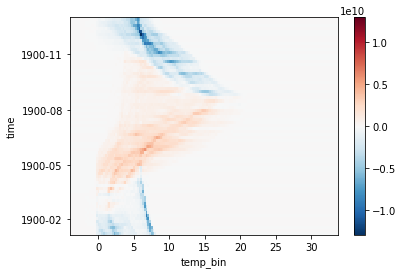

In [234]:
dMdt.plot()

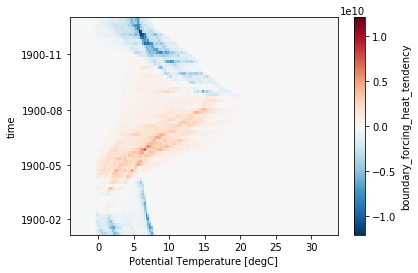

In [235]:
E_tot = xr.zeros_like(E['boundary_forcing_heat_tendency'])
for var in E.data_vars:
    E_tot += E[var]
E_tot.plot()

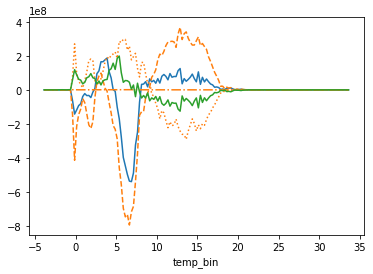

In [236]:
residual = dMdt - E_tot
# dMdt.mean('time').plot()
E_tot.mean('time').plot()
E['opottempdiff'].mean('time').plot(linestyle=':',color='tab:orange')
E['boundary_forcing_heat_tendency'].mean('time').plot(linestyle='--',color='tab:orange')
E['internal_heat_heat_tendency'].mean('time').plot(linestyle='-.',color='tab:orange')
residual.mean('time').plot(color='tab:green')

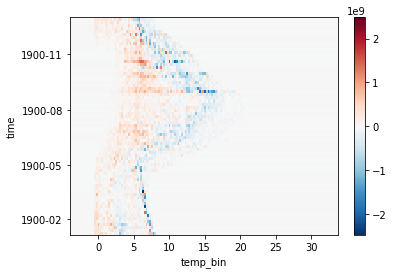

In [238]:
residual.plot()

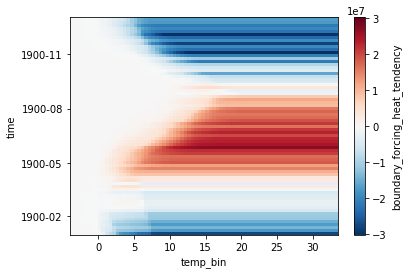

In [74]:
def calc_wmt(l,dls,c=None,ps,l_i_vals,volume,weight_dl=None,weight_p=None,dims=['xh','yh','zl'],greaterthan=True,dim_time='time'):
    '''volume is a time-varying array of model grid volumes'''
    
    
    delta_t = ds['average_DT'].astype('timedelta64[s]')
    # Get layer contours at midpoints
    l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])
    
    # Calculate volume/mass/tracer mass change through time
    if c is None:
        content = volume
    else:
        content = c*volume
        
    C = calc_volumetric_cumsum(l=l,p=content,l_l_vals=l_l_vals,weight=None,dims=dims,greaterthan=True)
    dC = C.diff('time')

In [148]:
dt = np.array([86400]).astype('timedelta64[s]')
DT = xr.DataArray(dt)
DT
DT_

<xarray.DataArray (dim_0: 1)>
array([86400000000000], dtype='timedelta64[ns]')
Dimensions without coordinates: dim_0